In [2]:
from DataManagement.data_manager import DataManager
from DataManagement.coin_data import CoinData
from constants import ATR_ABNORMALITY_COLUMN
# libs
import pandas as pd
import numpy as np

# plotting
import seaborn as sn

In [3]:
data_manager = DataManager()

In [4]:
coin_symbol_list = ["BTCUSDT", "ETHUSDT", "ADAUSDT", "LTCUSDT"]
feature = "close_pct"
kline_size = "1h"
main_coin_symbol = "BTCUSDT"

In [5]:
main_1h_df = data_manager.get_historical_data_CoinData(main_coin_symbol, kline_size="1h").df
main_abnromal_timestamps = main_1h_df[main_1h_df[ATR_ABNORMALITY_COLUMN] == 1].index

In [6]:
coin_data_list = [data_manager.get_historical_data_CoinData(coin_symbol, kline_size="1m") for coin_symbol in coin_symbol_list]

# Join close_pct columns of all coins togther

In [7]:
df = pd.DataFrame(index=coin_data_list[0].df.index)

for coin_data in coin_data_list:
    df = df.join(coin_data.df[feature], how="outer", rsuffix=f"_{coin_data.coin_symbol}", on="timestamp")
df.rename(columns={"close_pct":f"close_pct_{coin_data_list[0].coin_symbol}"}, inplace=True)    
df.dropna(inplace=True)
df.drop(columns=["timestamp"])
df.set_index("timestamp", inplace=True)

In [8]:
df

,close_pct_BTCUSDT,close_pct_ETHUSDT,close_pct_ADAUSDT,close_pct_LTCUSDT
timestamp,,,,
2018-04-17 04:03:00,0.000410,0.000000,-0.033037,0.000998
2018-04-17 04:04:00,0.000210,0.000374,0.021373,-0.001840
2018-04-17 04:05:00,-0.000368,0.000000,0.000000,-0.000077
2018-04-17 04:06:00,0.000415,-0.000020,0.012338,0.000230
2018-04-17 04:07:00,-0.000383,0.000788,-0.011298,0.000614
...,...,...,...,...
2021-06-24 09:28:00,0.000537,0.000052,0.000669,0.000681
2021-06-24 09:28:00,0.000007,0.000268,0.000669,0.000681
2021-06-24 09:28:00,0.000007,0.000052,0.000669,0.000681


In [9]:
resampled_list = list(df.resample(rule="1h"))
alltime_correlation_matrix_list, abnormal_correlation_matrix_list = [],[]

skipping_counter = 0
for timestamp, temp_df in resampled_list:
        
    if temp_df.empty:
        skipping_counter += 1
        continue
    temp_correl_matrix = temp_df.corr(method="pearson").to_numpy()
    if np.any(np.isnan(temp_correl_matrix)):
        skipping_counter += 1
        continue
    
    if timestamp in main_abnromal_timestamps:
        abnormal_correlation_matrix_list.append(temp_correl_matrix)
    
    alltime_correlation_matrix_list.append(temp_correl_matrix)
# transfrom to np.array
abnormal_correlation_matrix_list = np.array(abnormal_correlation_matrix_list)
alltime_correlation_matrix_list = np.array(alltime_correlation_matrix_list)
# print skipping precent
print(f"skipping precent {(skipping_counter/len(resampled_list))*100} %")

skipping precent 0.3006227184882972 %


In [11]:
alltime_correlation_matrix_list.mean(axis=0)

array([[1.        , 0.71185607, 0.49268135, 0.60342897],
       [0.71185607, 1.        , 0.48861627, 0.6069373 ],
       [0.49268135, 0.48861627, 1.        , 0.4346672 ],
       [0.60342897, 0.6069373 , 0.4346672 , 1.        ]])

In [12]:
abnormal_correlation_matrix_list.mean(axis=0)

array([[1.        , 0.81428467, 0.68784513, 0.75168299],
       [0.81428467, 1.        , 0.67468543, 0.75865663],
       [0.68784513, 0.67468543, 1.        , 0.63178561],
       [0.75168299, 0.75865663, 0.63178561, 1.        ]])

In [40]:
tuple([3]*3)

(3, 3, 3)

In [53]:
def plot_heatmap(correl_df, title):
    mean_corr_df = pd.DataFrame(index=df.columns, columns=df.columns, data=correl_df)

    fig_size = max(len(df.columns), 1)
    sn.set(rc={"figure.figsize":tuple([fig_size]*2)})
    sn.heatmap(mean_corr_df, annot=True).set(title=title);

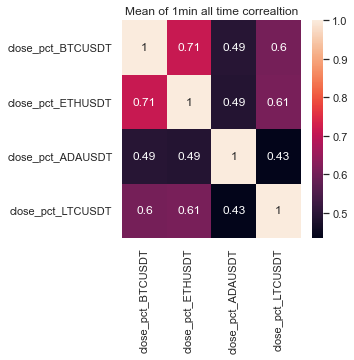

In [54]:
plot_heatmap(alltime_correlation_matrix_list.mean(axis=0), "Mean of 1min all time correaltion")

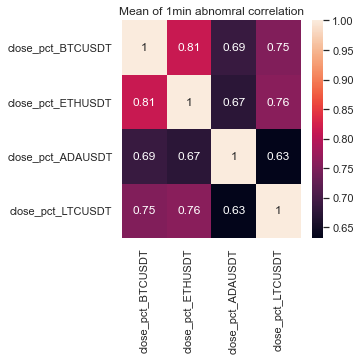

In [55]:
plot_heatmap(abnormal_correlation_matrix_list.mean(axis=0), "Mean of 1min abnomral correlation")

In [50]:
l1 = np.array([1,2])
l2 = np.array([3,4])
l2-l1

array([2, 2])

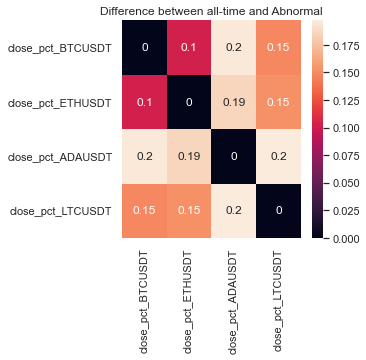

In [56]:
plot_heatmap(abnormal_correlation_matrix_list.mean(axis=0)-alltime_correlation_matrix_list.mean(axis=0), "Difference between all-time and Abnormal")